In [1]:
import re
import pandas as pd
import os
import subprocess
import tempfile
from io import StringIO

In [2]:
data_location = "/home/t/ticeraskin/Desktop/project/Remuszka_Shared/GovRnD/data/"

In [3]:
def extract_with_system_tools(zip_path, outdir):
    from shutil import which

    # Try 7zip first (handles all ZIP compression methods)
    for exe in ["7z", "7za", "7zr"]:
        seven = which(exe)
        if seven:
            cmd = [seven, "x", zip_path, f"-o{outdir}", "-y"]
            try:
                subprocess.run(cmd, check=True)
                print(f"Extracted with {exe}.")
                return True
            except subprocess.CalledProcessError:
                pass

    # Try unzip (may or may not support your method)
    unzip = which("unzip")
    if unzip:
        try:
            subprocess.run([unzip, "-o", zip_path, "-d", outdir], check=True)
            print("Extracted with unzip.")
            return True
        except subprocess.CalledProcessError:
            pass

    raise RuntimeError("No extractor available (7z/7za/7zr/unzip not found).")


def load_zip_as_dataframes(zip_path):
    # Temporary directory for extraction
    with tempfile.TemporaryDirectory() as temp_dir:

        # Extract using 7-Zip or unzip
        extract_with_system_tools(zip_path, temp_dir)

        dfs = {}

        # Walk extracted files
        for root, dirs, files in os.walk(temp_dir):
            for filename in files:
                path = os.path.join(root, filename)

                # Load file contents
                try:
                    with open(path, "r", encoding="utf-8", errors="ignore") as f:
                        text = f.read()
                except Exception:
                    with open(path, "rb") as f:
                        # binary fallback
                        dfs[filename] = pd.DataFrame({"bytes": [f.read()]})
                        continue

                # Try CSV parsing
                buffer = StringIO(text)
                try:
                    df = pd.read_csv(buffer)
                except Exception:
                    # fallback: line-per-row
                    df = pd.DataFrame({"text": text.splitlines()})

                dfs[filename] = df

        return dfs

def merge_yearly_files(dfs, base_name="base_file"):
    """
    dfs: dict {filename: DataFrame}
    base_name: the prefix before _YYYY.csv
    Returns a concatenated DataFrame with an added column 'year'.
    """
    pattern = re.compile(rf"^{base_name}_(\d{{4}})\.csv$")

    frames = []

    for filename, df in dfs.items():
        match = pattern.match(filename)
        if match:
            year = int(match.group(1))
            df = df.copy()
            df["year"] = year
            frames.append(df)

    if not frames:
        raise ValueError(f"No files found matching pattern {base_name}_YYYY.csv")

    return pd.concat(frames, ignore_index=True)


In [4]:
# Bringing in all the contracts
## Reading zip files
dfs = load_zip_as_dataframes(data_location+"G Contracts/base_files.zip")
dfs.keys()

## Putting all contracts into one file
contracts = merge_yearly_files(dfs)

## Removing zeros for size concerns
contracts_nonzero = contracts[contracts['federal_action_obligation']!=0]


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,72 CPUs Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz (50654),ASM,AES-NI)

Scanning the drive for archives:
1 file, 3521570299 bytes (3359 MiB)

Extracting archive: /home/t/ticeraskin/Desktop/project/Remuszka_Shared/GovRnD/data/G Contracts/base_files.zip
--
Path = /home/t/ticeraskin/Desktop/project/Remuszka_Shared/GovRnD/data/G Contracts/base_files.zip
Type = zip
Physical Size = 3521570299

Everything is Ok

Files: 25
Size:       16770993250
Compressed: 3521570299
Extracted with 7za.


/tmp/ipykernel_369524/3614927591.py:56: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(buffer)
/tmp/ipykernel_369524/3614927591.py:56: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(buffer)
/tmp/ipykernel_369524/3614927591.py:56: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(buffer)
/tmp/ipykernel_369524/3614927591.py:56: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(buffer)
/tmp/ipykernel_369524/3614927591.py:56: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(buffer)
/tmp/ipykernel_369524/3614927591.py:56: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(buffer

In [5]:
# Loading in the contracts from Lydia
psc_contracts = pd.read_csv(data_location + "G Contracts/ticeraskin_remuszka.csv")
psc_contracts_nonzero = psc_contracts[psc_contracts['federal_action_obligation']!=0]

/tmp/ipykernel_369524/1491015187.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  psc_contracts = pd.read_csv(data_location + "G Contracts/ticeraskin_remuszka.csv")


In [6]:
# Getting the contracts all together
contracts_full = pd.merge(
    contracts_nonzero,
    psc_contracts_nonzero,
    on="contract_transaction_unique_key",
    how="inner",
    suffixes=("_nonzero", "_psc")
)

In [7]:
contracts_full_nonan = contracts_full.dropna(subset=['product_or_service_code'])

RD_contracts = contracts_full_nonan[
    contracts_full_nonan['product_or_service_code'].str.startswith("A")
].copy()

print(RD_contracts.shape)

(1196155, 15)


In [8]:
RD_copy = RD_contracts.copy()   # rename as needed

# Make sure contract_date is datetime
RD_copy['action_date'] = pd.to_datetime(RD_copy['action_date'])

# Sort for deterministic behavior
RD_copy = RD_copy.sort_values(['contract_award_unique_key', 'action_date'])

# List to hold indices of rows to remove
to_remove = set()

# Loop through each key group
for key, g in RD_copy.groupby('contract_award_unique_key'):
    g = g.sort_values('action_date')
    g_idx = g.index.tolist()
    
    for i in range(len(g) - 1):
        first = g.iloc[i]
        second = g.iloc[i + 1]
        
        # Must be within 30 days
        if abs(second.action_date - first.action_date) <= pd.Timedelta(days=30):
            
            # Check offsetting rule
            if abs(first.federal_action_obligation_nonzero + second.federal_action_obligation_nonzero) < 0.05 * abs(first.federal_action_obligation_nonzero):
                to_remove.add(first.name)
                to_remove.add(second.name)

# Drop all offsetting rows
RD_clean = RD_copy.drop(index=to_remove).copy()

In [9]:
fips_walk = pd.read_csv(data_location + "Misc/ssa_fips_state_county_2025.csv")

In [24]:
# Convert both columns to strings
RD_clean["prime_award_transaction_place_of_performance_county_fips_code"] = \
    RD_clean["prime_award_transaction_place_of_performance_county_fips_code"].astype(str)

fips_walk["fipscounty"] = fips_walk["fipscounty"].astype(str)

# Optional: zero-pad to 5 digits if needed
#RD_contracts["prime_award_transaction_place_of_performance_county_fips_code"] = \
#    RD_contracts["prime_award_transaction_place_of_performance_county_fips_code"].str.zfill(5)

fips_walk["fipscounty"] = fips_walk["fipscounty"].str.zfill(5)

local_merge = pd.merge(RD_clean, fips_walk, left_on = "prime_award_transaction_place_of_performance_county_fips_code", right_on = "fipscounty")

local_merge = local_merge.drop("fipscounty", axis = 1)

local_merge = local_merge.rename(columns = {"prime_award_transaction_place_of_performance_county_fips_code":"fipscounty"})

In [75]:
psc_codes = pd.read_excel(data_location + "Misc/PSC April 2025.xlsx")

RD_describe = pd.merge(local_merge, psc_codes, left_on = "product_or_service_code", right_on = "PSC CODE")

col = 'PRODUCT AND SERVICE CODE FULL NAME (DESCRIPTION)'

# 1. Extract the type part after the dash
RD_describe['research_type'] = (
    RD_describe[col]
    .str.split('-', n=1)
    .str[1]
    .str.lower()
    .str.strip()
)

# 2. Create a single categorical column: basic / applied / other
def classify_research(x):
    if pd.isna(x):
        return "other"
    if "basic" in x:
        return "basic"
    if ("applied" in x) or ("development" in x):
        return "applied"
    return "other"

RD_describe['research_category'] = RD_describe['research_type'].apply(classify_research)

In [76]:
RD_describe["period_of_performance_start_date"] = pd.to_datetime(
    RD_describe["period_of_performance_start_date"], errors='coerce'
)
RD_describe["period_of_performance_current_end_date"] = pd.to_datetime(
    RD_describe["period_of_performance_current_end_date"], errors='coerce'
)
RD_describe["action_date"] = pd.to_datetime(
    RD_describe["action_date"], errors='coerce'
)

RD_describe = RD_describe[
    (RD_describe["action_date"] < "2025-01-01") &
    (RD_describe["period_of_performance_start_date"] < "2025-01-01") &
    (RD_describe["period_of_performance_current_end_date"] < "2100-01-01")
]

In [64]:
def build_county_spending_timeseries_wide_fast(
    df,
    county_col="fipscounty",
    activity_col="research_category",
    start_col="period_of_performance_start_date",
    end_col="period_of_performance_current_end_date",
    amount_col="federal_action_obligation_nonzero",
    freq="MS"
):
    """
    Faster version: vectorized expansion of monthly periods without explicit for-loop.
    """

    # Ensure datetime
    df[start_col] = pd.to_datetime(df[start_col], errors="coerce")
    df[end_col]   = pd.to_datetime(df[end_col], errors="coerce")

    # Remove invalid dates
    df = df.dropna(subset=[start_col, end_col])
    df = df[df[end_col] >= df[start_col]]

    # ---- Group contracts before expansion ----
    grouped = (
        df.groupby([county_col, activity_col, start_col, end_col], as_index=False)[amount_col].sum()
    )

    print(f"Number of grouped contract periods: {len(grouped):,}")

    # Compute number of months per contract
    grouped["num_months"] = ((grouped[end_col].dt.to_period("M") - grouped[start_col].dt.to_period("M")).apply(lambda x: x.n + 1))
    grouped = grouped[grouped["num_months"] > 0]

    # Repeat each row by number of months
    repeated = grouped.loc[grouped.index.repeat(grouped["num_months"])].copy()

    # Generate offsets for months
    repeated["month_offset"] = repeated.groupby([county_col, activity_col, start_col, end_col]).cumcount()

    # Compute actual month
    repeated["month"] = repeated[start_col] + pd.to_timedelta(repeated["month_offset"]*30, unit="D")
    # Align to month start
    repeated["month"] = repeated["month"].dt.to_period("M").dt.to_timestamp()

    # Allocate spending equally
    repeated["spending"] = repeated[amount_col] / repeated["num_months"]

    # Aggregate and pivot
    wide = repeated.groupby([county_col, "month", activity_col])["spending"].sum().unstack(fill_value=0).reset_index()

    return wide


In [65]:
# creating a county level time series where each contract is divied amongst its active dates
RD_across_time = build_county_spending_timeseries_wide_fast(RD_describe)

Number of grouped contract periods: 848,055


In [66]:
# Cutting to dates we care about
RD_across_time_cut = RD_across_time[(RD_across_time["month"]>="2001-01-01") & (RD_across_time["month"]<="2024-01-01")]

In [90]:
RD_across_time_cut

research_category,fipscounty,month,applied,basic,other
0,10001.0,2003-07-01,5513.513514,0.000000,2756.756757
1,10001.0,2003-08-01,5513.513514,0.000000,2756.756757
2,10001.0,2003-09-01,5513.513514,0.000000,2756.756757
3,10001.0,2003-10-01,5513.513514,0.000000,2756.756757
4,10001.0,2003-11-01,5513.513514,0.000000,2756.756757
...,...,...,...,...,...
248257,8123.0,2023-09-01,417659.668718,11071.555556,214365.612137
248258,8123.0,2023-10-01,417659.668718,11071.555556,214365.612137
248259,8123.0,2023-11-01,417659.668718,11071.555556,214365.612137
248260,8123.0,2023-12-01,417659.668718,11071.555556,214365.612137


/tmp/ipykernel_369524/2269815838.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RD_across_time_cut['month'] = pd.to_datetime(RD_across_time_cut['month'])


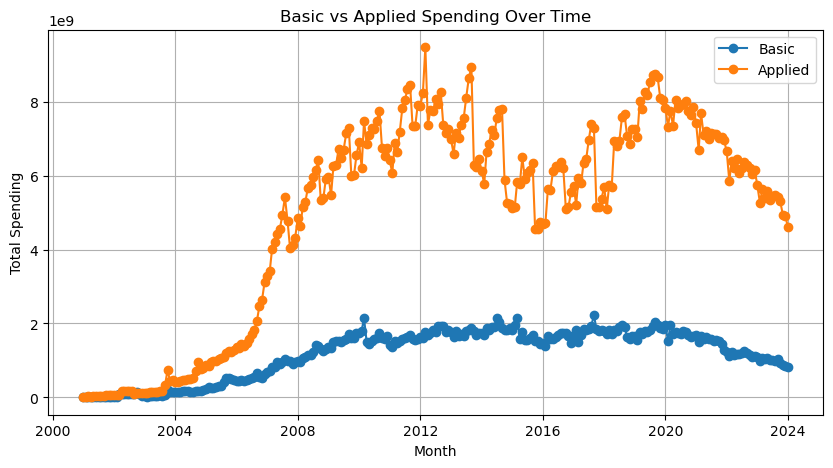

In [68]:
#Making a lil plot
# Make sure your time column is datetime
RD_across_time_cut['month'] = pd.to_datetime(RD_across_time_cut['month'])

# Aggregate sums per month
monthly_sum = RD_across_time_cut.groupby('month')[['basic', 'applied']].sum().reset_index()

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_sum['month'], monthly_sum['basic'], label='Basic', marker='o')
plt.plot(monthly_sum['month'], monthly_sum['applied'], label='Applied', marker='o')
plt.xlabel('Month')
plt.ylabel('Total Spending')
plt.title('Basic vs Applied Spending Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# Code that aggregates contract into the sum of their lifetime obligations (tall)

# Sort so "first" is meaningful
RD_tall_contracts = RD_describe.sort_values(['contract_award_unique_key', 'action_date'])

# Aggregation function
RD_tall_contracts = (
    RD_tall_contracts
    .groupby('contract_award_unique_key')
    .agg(
        action_date=('action_date', 'first'),
        federal_action_obligation_nonzero=('federal_action_obligation_nonzero', 'sum'),
        product_or_service_code=('product_or_service_code', 'first'),
        awarding_agency_code=('awarding_agency_code', 'first'),
        fipscounty=(
            'fipscounty', 
            'first'
        ),
        research_category = (
            'research_category',
            'first'
        )
    )
    .reset_index()
)

RD_tall_contracts = RD_tall_contracts[RD_tall_contracts['federal_action_obligation_nonzero']>0]

In [87]:
# Aggregating tall contracts (i.e. summing contracts into one singular transaction)

RD_tall_contracts = pd.merge(RD_tall_contracts, dfs['crosswalk_awarding_agency.csv'], on = "awarding_agency_code")

# Ensure action_date is datetime
RD_tall_contracts['action_date'] = pd.to_datetime(RD_tall_contracts['action_date'], errors='coerce')

# Create a monthly period
RD_tall_contracts['year_month'] = RD_tall_contracts['action_date'].values.astype('datetime64[M]')

# -----------------------------
# 1. Denominator: fips_code × month × research_category
# -----------------------------
agg_county_research_tall = (
    RD_tall_contracts
    .groupby(['fipscounty', 'year_month', 'research_category'], as_index=False)
    ['federal_action_obligation_nonzero']
    .sum()
)

# Aggregate sums (same as you already did)
agg_county_research_tall = (
    RD_tall_contracts
    .groupby(['fipscounty', 'year_month', 'research_category'], as_index=False)
    ['federal_action_obligation_nonzero']
    .sum()
)

# Pivot to wide format: one column per research_category
agg_county_research_wide = agg_county_research_tall.pivot_table(
    index=['fipscounty', 'year_month'],
    columns='research_category',
    values='federal_action_obligation_nonzero',
    fill_value=0
).reset_index()

# Optional: flatten column names
agg_county_research_wide.columns.name = None


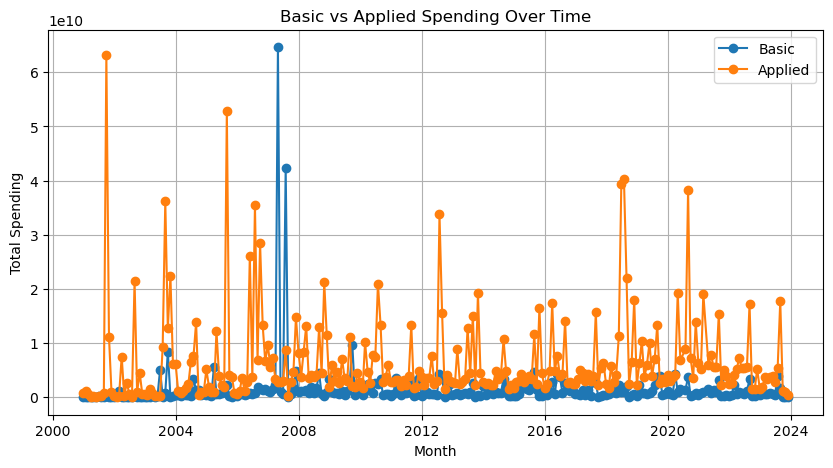

In [89]:
#Making a lil plot
# Make sure your time column is datetime
agg_county_research_wide['year_month'] = pd.to_datetime(agg_county_research_wide['year_month'])

# Aggregate sums per month
monthly_sum = agg_county_research_wide.groupby('year_month')[['basic', 'applied']].sum().reset_index()

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_sum['year_month'], monthly_sum['basic'], label='Basic', marker='o')
plt.plot(monthly_sum['year_month'], monthly_sum['applied'], label='Applied', marker='o')
plt.xlabel('Month')
plt.ylabel('Total Spending')
plt.title('Basic vs Applied Spending Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
# Raw merge
# Ensure action_date is datetime
RD_describe['action_date'] = pd.to_datetime(RD_describe['action_date'], errors='coerce')

# Create a monthly period column
RD_describe['year_month'] = RD_describe['action_date'].dt.to_period('M')

# Group by month, research category, and county
agg_tall = (
    RD_describe
    .groupby(['year_month', 'research_category', 'fipscounty'], as_index=False)
    .agg(
        federal_action_obligation_nonzero=('federal_action_obligation_nonzero', 'sum')
    )
)

# Pivot to wide format: one column per research category
agg_untouched = agg_tall.pivot_table(
    index=['fipscounty', 'year_month'],
    columns='research_category',
    values='federal_action_obligation_nonzero',
    fill_value=0
).reset_index()

# Optional: flatten column names
agg_untouched.columns.name = None

# Convert year_month back to timestamp if desired
agg_untouched['year_month'] = agg_untouched['year_month'].dt.to_timestamp()

In [125]:
# merging everything

RD_across_time_cut = RD_across_time_cut.rename(columns = {"month":"year_month"})

wide_and_raw = pd.merge(agg_untouched, agg_county_research_wide, on = ["fipscounty", "year_month"], suffixes = ["_raw", "_tall"], how = "outer")
RD_panel = pd.merge(wide_and_raw, RD_across_time_cut, on = ["fipscounty", "year_month"], how = "outer")
RD_panel = RD_panel.rename(columns = {"basic":"basic_wide", "applied":"applied_wide", "other":"other_wide"})
RD_panel = RD_panel.merge(fips_walk, on = "fipscounty").fillna(0)


In [126]:
RD_panel.to_csv(data_location + 'G Contracts/county_panel.csv', index = False)